In [8]:
import os
max_threads = str(40)
os.environ["OMP_NUM_THREADS"] = max_threads # export OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = max_threads # export OPENBLAS_NUM_THREADS=4 
os.environ["MKL_NUM_THREADS"] = max_threads # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = max_threads # export VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = max_threads # export NUMEXPR_NUM_THREADS=6

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import scipy
import os
import scipy.io as sio


In [3]:
adata1 = sc.read_h5ad("adata/iGABA_post_filtered_doublets.h5ad")

In [4]:
adata1.var_names_make_unique()
adata1.obs['sample'] = 'iGABA_post'

In [5]:
adata = adata1
adata.obs_names_make_unique()

In [7]:
adata

AnnData object with n_obs × n_vars = 85756 × 62710
    obs: 'sample', 'species', 'gene_count', 'tscp_count', 'mread_count', 'bc1_well', 'bc2_well', 'bc3_well', 'bc1_wind', 'bc2_wind', 'bc3_wind', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'percent_mito', 'n_counts', 'outlier', 'mt_outlier', 'doublet_score', 'predicted_doublet'
    var: 'gene_id', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'scrublet', 'sample_colors'

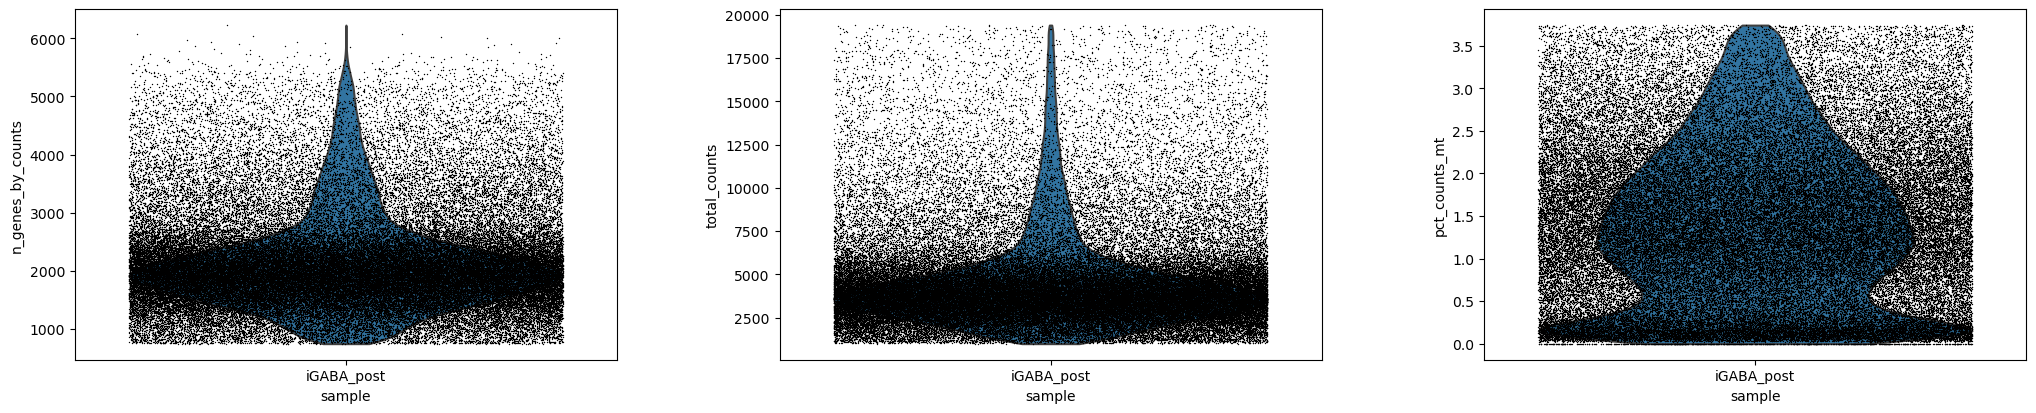

In [6]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],groupby='sample',
             jitter=0.4, multi_panel=True)


In [7]:
sc.pp.filter_genes(adata, min_cells=3)
adata.raw = adata
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)

/links/groups/treutlein/USERS/jjans/anaconda3/envs/py_jjans_3.10_scanpy/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


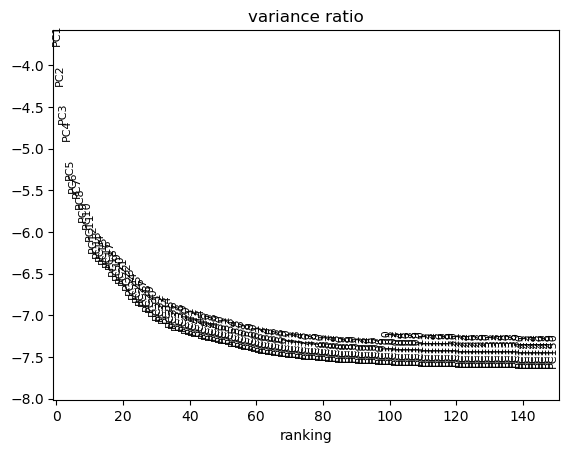

In [8]:
sc.tl.pca(adata, svd_solver='arpack',n_comps=150)
sc.pl.pca_variance_ratio(adata, log=True,n_pcs=150)

In [9]:
adata.write_h5ad("scanpy/iGABA_post_scaled.h5ad")

In [3]:
adata = sc.read_h5ad("scanpy/iGABA_post_scaled.h5ad")

In [10]:
from threadpoolctl import threadpool_limits
with threadpool_limits(limits=50, user_api='blas'):
    sc.pp.neighbors(adata, n_neighbors=30, n_pcs=80)
    sc.tl.umap(adata)
    sc.tl.tsne(adata)

In [11]:
adata.write_h5ad("scanpy/iGABA_post_dr.h5ad")

In [12]:
sc.tl.leiden(adata,resolution=4,key_added='leiden_4')
sc.tl.leiden(adata,resolution=10,key_added='leiden_10')


In [13]:
adata.write_h5ad("scanpy/iGABA_post_dr_clustered.h5ad")

In [14]:
adata1 = sc.read_h5ad("adata/iGABA_post_filtered_doublets.h5ad")
adata1.var_names_make_unique()
adata1.obs['sample'] = 'iGABA_post'
adata_raw = adata1

In [15]:
adata_raw.obs = adata.obs
adata_raw.obsm = adata.obsm
adata_raw.obsp = adata.obsp

In [16]:
adata_raw.write_h5ad("scanpy/iGABA_post_dr_clustered_raw.h5ad")

In [17]:
adata_raw

AnnData object with n_obs × n_vars = 85756 × 62710
    obs: 'sample', 'species', 'gene_count', 'tscp_count', 'mread_count', 'bc1_well', 'bc2_well', 'bc3_well', 'bc1_wind', 'bc2_wind', 'bc3_wind', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'percent_mito', 'n_counts', 'outlier', 'mt_outlier', 'doublet_score', 'predicted_doublet', 'leiden_4', 'leiden_10'
    var: 'gene_id', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'scrublet'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    obsp: 'distances', 'connectivities'

In [ ]:
# Load gene lists
ion_channels = pd.read_csv("/home/jjanssens/jjans/resources/geneLists/HGNC/human_ion_channels.txt", sep="\t")['Approved symbol'].unique()
tfs = pd.read_csv("/home/jjanssens/jjans/resources/resources.aertslab.org/cistarget/tf_lists/allTFs_hg38.txt", sep="\t", header=None)[0].unique()
info_genes = list(set(ion_channels) | set(tfs))

from clustering_functions import *

In [19]:
adata_raw = merge_clusters_adata(adata_raw,base_resolution='leiden_10',max_iter=20)
adata.obs['merged_clusters_from_10'] = adata.obs['merged_clusters']

1
calculating DEGs


  0%|          | 0/123 [00:00<?, ?it/s]

merging clusters
2
calculating DEGs


  0%|          | 0/97 [00:00<?, ?it/s]

calculating cluster summaries
merging clusters
3
calculating DEGs


  0%|          | 0/83 [00:00<?, ?it/s]

calculating cluster summaries
merging clusters
4
calculating DEGs


  0%|          | 0/79 [00:00<?, ?it/s]

calculating cluster summaries
merging clusters
5
calculating DEGs


  0%|          | 0/78 [00:00<?, ?it/s]

calculating cluster summaries
merging clusters
number of iterations needed 5
original number of clusters 123
merged number of clusters 78


In [20]:
adata_raw.write_h5ad("scanpy/iGABA_post_dr_clustered_raw_merged.h5ad")

In [21]:
adata_raw

AnnData object with n_obs × n_vars = 85756 × 62710
    obs: 'sample', 'species', 'gene_count', 'tscp_count', 'mread_count', 'bc1_well', 'bc2_well', 'bc3_well', 'bc1_wind', 'bc2_wind', 'bc3_wind', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'percent_mito', 'n_counts', 'outlier', 'mt_outlier', 'doublet_score', 'predicted_doublet', 'leiden_4', 'leiden_10', 'merged_clusters', 'final_clustering', 'final_clustering_reset', 'merged_clusters_from_10'
    var: 'gene_id', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'scrublet'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    obsp: 'distances', 'connectivities'

In [ ]:
for a in alla:
    sc.pl.umap(adata,color=a,legend_loc='on data')
    plt.show()
    plt.close()

In [ ]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=80)
sc.tl.umap(adata)


In [ ]:
ion_channels = pd.read_csv("/home/jjanssens/jjans/resources/geneLists/HGNC/human_ion_channels.txt",sep="\t")
ion_channels = list(set(ion_channels['Approved symbol']))

HG_TFS_FNAME = '/home/jjanssens/jjans/resources/resources.aertslab.org/cistarget/tf_lists/allTFs_hg38.txt'
tfs = pd.read_csv(HG_TFS_FNAME,sep="\t",header=None)
tfs = list(tfs[0])

info_genes = ion_channels + tfs
